#  Word Embeddings (CBOW model)
This assignment we will compute word embeddings and train model from scratch, implement forward (cost function of cross entropy) and backpropagation (parameters), finally visualize word vectors (PCA). 


## 1. The Continuous bag of words model (CBOW)


In [17]:
import nltk
import re   
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter
from scipy import linalg
from collections import defaultdict

In [18]:
nltk.data.path.append('.')
with open('shakespeare.txt') as f:
    data = f.read()                                                 
data = re.sub(r'[,!?;-]', '.',data)                                 
data = nltk.word_tokenize(data)                                     
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    
print("Number of tokens:", len(data),'\n', data[:10], '\n')    

fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(10)) 

Number of tokens: 60996 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend'] 

Size of vocabulary:  5778
Most frequent tokens:  [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1257), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('a', 752)]


In [19]:
# Converting words to indices.
def get_dict(data):
#     words = nltk.word_tokenize(data)
    words = sorted(list(set(data)))
    n = len(words)
    idx = 0
    word2Ind = {}
    Ind2word = {}
    for k in words:
        word2Ind[k] = idx
        Ind2word[idx] = k
        idx += 1
    return word2Ind, Ind2word

word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V, '\n')

Size of vocabulary:  5778 



## 2. Training the Model

In [20]:
# Initialize_model
def initialize_model(N,V, random_seed=1):
    np.random.seed(random_seed)
    W1 = np.random.rand(N,V)
    W2 = np.random.rand(V,N)
    b1 = np.random.rand(N,1)
    b2 = np.random.rand(V,1)
    return W1, W2, b1, b2

# Softmax
def softmax(z):
    e_z = np.exp(z)
    yhat = e_z/np.sum(e_z,axis=0)
    return yhat

# Forward_prop
def forward_prop(x, W1, W2, b1, b2):
    h = np.dot(W1,x)+b1
    h = np.maximum(0,h)
    z = np.dot(W2,h)+b2
    return z, h

In [21]:
def sigmoid(z):
    # sigmoid function
    return 1.0/(1.0+np.exp(-z))

def get_idx(words, word2Ind):
    idx = []
    for word in words:
        idx = idx + [word2Ind[word]]
    return idx

def pack_idx_with_frequency(context_words, word2Ind):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2Ind)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed

def get_vectors(data, word2Ind, V, C):
    i = C
    while True:
        y = np.zeros(V)
        x = np.zeros(V)
        center_word = data[i]
        y[word2Ind[center_word]] = 1
        context_words = data[(i - C):i] + data[(i+1):(i+C+1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_frequency(context_words, word2Ind):
            x[idx] = freq/num_ctx_words
        yield x, y
        i += 1
        if i >= len(data):
            print('i is being set to 0')
            i = 0

def get_batches(data, word2Ind, V, C, batch_size):
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2Ind, V, C):
        while len(batch_x) < batch_size:
            batch_x.append(x)
            batch_y.append(y)
        else:
            yield np.array(batch_x).T, np.array(batch_y).T
            batch = []

In [9]:
def compute_cost(y, yhat, batch_size):
    # cost function 
    logprobs = np.multiply(np.log(yhat),y) + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    l1 = np.dot(W2.T,(yhat-y))
    l1[l1<0] = 0.0
    grad_W1 = (1/batch_size)*np.dot(l1,x.T) 
    grad_W2 = (1/batch_size)*np.dot(yhat-y,h.T)
    grad_b1 = np.sum((1/batch_size)*np.dot(l1,x.T),axis=1,keepdims=True)
    grad_b2 = np.sum((1/batch_size)*np.dot(yhat-y,h.T),axis=1,keepdims=True)
    return grad_W1, grad_W2, grad_b1, grad_b2

def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    batch_size = 128
    iters = 0
    C = 2
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        z, h = forward_prop(x, W1, W2, b1, b2)
        yhat = softmax(z)
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        W1 -= alpha*grad_W1 
        W2 -= alpha*grad_W2
        b1 -= alpha*grad_b1
        b2 -= alpha*grad_b2        
        iters += 1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66            
    return W1, W2, b1, b2

# test your function
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 0.107177
iters: 20 cost: 0.038644
iters: 30 cost: 0.023685
iters: 40 cost: 0.017095
iters: 50 cost: 0.013380
iters: 60 cost: 0.010995
iters: 70 cost: 0.009333
iters: 80 cost: 0.008108
iters: 90 cost: 0.007168
iters: 100 cost: 0.006423
iters: 110 cost: 0.005992
iters: 120 cost: 0.005633
iters: 130 cost: 0.005314
iters: 140 cost: 0.005030
iters: 150 cost: 0.004774


## 3. Visualizing the word vectors 

In [22]:
# visualizing the word vectors 
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','wolf', 'rich','happy','sad']
embs = (W1.T + W2)/2.0
 
# Matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  

(10, 50) [2745, 3951, 2961, 3023, 5675, 1452, 5674, 4191, 2316, 4278]


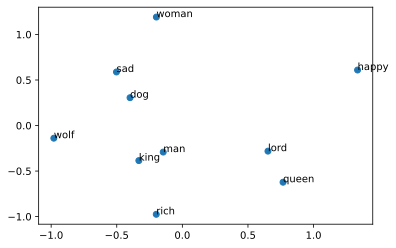

In [23]:
def compute_pca(data, n_components=2):
    m, n = data.shape
    data -= data.mean(axis=0)
    R = np.cov(data, rowvar=False)
    # use 'eigh' rather than 'eig' since R is symmetric!!
    evals, evecs = linalg.eigh(R)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:, idx]
    evals = evals[idx]
    evecs = evecs[:, :n_components]
    return np.dot(evecs.T, data.T).T

result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

You can see that man and king are next to each other. However, we have to be careful with the interpretation of this projected word vectors, since the PCA depends on the projection -- as shown in the following illustration.

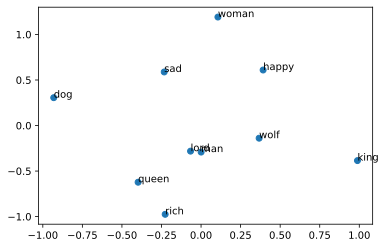

In [14]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()

Reference: https://www.coursera.org/learn/probabilistic-models-in-nlp/home/week/4